## Car Pole

### Description
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

### Actions
There are 4 discrete deterministic actions:
```
    0: push to the left
    1: push to the right
```

### Observations
```
0   Cart Position (x-axis)  -4.8                4.8
1   Cart Velocity           -Inf                Inf
2   Pole Angle              ~ -0.418 rad (-24°) ~ 0.418 rad (24°)
3   Pole Angular Velocity   -Inf                Inf
```
### Reward
+1 for every step taken, including the termination step. The threshold for rewards is 475 for v1.  
(The task is setup as episodic. To set it up as non-episodic (AKA continuing task) the reward would be −1 on each failure and zero at all other times)

### Starting State

All observations are assigned a uniformly random value in (-0.05, 0.05)
Episode Termination

### Termination conditions
```
Pole Angle is greater than ±12°
Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
Episode length is greater than 500
```



In [1]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
gym.__version__

'0.25.0'

In [2]:
env = gym.make('CartPole-v1', new_step_api=True)

In [3]:
env.spec

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=1)

In [11]:
state = env.reset()

In [13]:
action = env.action_space.sample()
action

1

In [14]:
new_state, reward, done, _, info = env.step(action)

In [15]:
env.step(action)

(array([-0.04196024,  0.39198658,  0.00373235, -0.6199233 ], dtype=float32),
 1.0,
 False,
 False,
 {})

There are uncountably-many states, so the q_learning methd doesn't work here

C:\Users\vahid\AppData\Roaming\Python\Python310\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
C:\Users\vahid\AppData\Roaming\Python\Python310\site-packages\gym\utils\seeding.py:95: DeprecationWarning: WARN: Function `rng.seed(seed)` is marked as deprecated and will be removed in the future. Please use `rng, seed = gym.utils.seeding.np_random(seed)` to create a separate generator instead.
  deprecation(


********Average reward per thousand episodes********

1000 :  -819.6330000000015
2000 :  -308.6950000000001
3000 :  -135.41899999999993
4000 :  -90.55600000000027
5000 :  -55.38199999999993
6000 :  -34.18000000000033
7000 :  -23.8650000000005
8000 :  -21.68200000000027
9000 :  -17.295000000000073
10000 :  -16.03099999999992


<Figure size 1080x720 with 0 Axes>

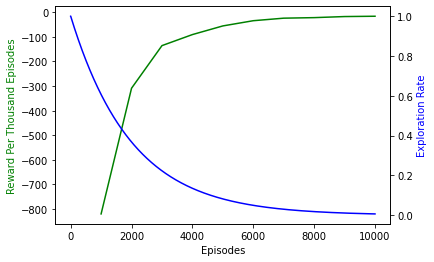

In [43]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

num_episodes = 10000
max_steps_per_episode = 500

learning_rate = 0.01
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0
exploration_decay_rate = 0.0005

RANDOM_SEED = 0
env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
env.action_space.seed(RANDOM_SEED)
env.action_space.np_random.seed(RANDOM_SEED)

q_table = np.zeros((state_space_size, action_space_size))

rewards_all_episodes = []
all_episodes_info = []
output = []
rewards = []

# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards_current_episode = 0
    step_count = 0
    steps = []
    for step in range(max_steps_per_episode):       
        #print(episode, step)

        step_count += 1

        # Exploration-exploitation trade-off
        exploration_rate_threshold = random.uniform(0, 1)

        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:]) 
        else:
            action = env.action_space.sample()

        steps.append(action)
        new_state, reward, terminated, _, info = env.step(action)

        # Update Q-table for Q(s,a)
        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
        
        state = new_state
        rewards_current_episode += reward        
        
        if terminated == True: # i.e. it didn't run out of steps
            rewards.append([episode, step, reward])
            if reward == -1:  # i.e. it didn't step on the cliff
              output.append(q_table.copy())
            break
    
    all_episodes_info.append([episode, exploration_rate, step_count, reward, steps])

    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)    
    
    rewards_all_episodes.append(rewards_current_episode)

# Calculate and print the average reward per thousand episodes
rewards_per_thosand_episodes = np.split(np.array(rewards_all_episodes), num_episodes/1000)
count = 1000
print("********Average reward per thousand episodes********\n")
for r in rewards_per_thosand_episodes:
    print(count, ": ", str(sum(r/1000)))
    count += 1000    

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(1000, num_episodes + 1, 1000), [ sum(i)/1000 for i in rewards_per_thosand_episodes ], 'g-')
ax2.plot([i[0] for i in all_episodes_info], [i[1] for i in all_episodes_info], 'b-')
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Reward Per Thousand Episodes', color='g')
ax2.set_ylabel('Exploration Rate', color='b')
plt.show()

In [37]:
import json
q = output[-1].astype(int).astype(str)
q = [ list(i) for i in q ]
for n in range(4):
  print(*[ json.dumps(list(i)).ljust(28).replace('"', "'").replace(', ', ',') for i in q[12*n:12*(n+1)] ])

['-10','-10','-10','-10'] ['-10','-10','-10','-10'] ['-9','-9','-9','-9']     ['-9','-9','-9','-9']     ['-8','-8','-8','-8']     ['-7','-7','-7','-7']     ['-6','-6','-6','-6']     ['-6','-6','-6','-6']     ['-5','-5','-5','-5']     ['-4','-4','-4','-4']     ['-3','-3','-3','-3']     ['-2','-2','-2','-3']    
['-10','-10','-10','-10'] ['-10','-10','-10','-10'] ['-9','-9','-9','-9']     ['-9','-9','-9','-9']     ['-8','-8','-8','-8']     ['-7','-7','-7','-7']     ['-6','-6','-6','-6']     ['-5','-5','-5','-6']     ['-5','-4','-4','-5']     ['-4','-3','-3','-4']     ['-3','-2','-2','-3']     ['-3','-2','-1','-3']    
['-11','-11','-12','-12'] ['-11','-10','-111','-12'] ['-10','-9','-111','-11'] ['-9','-8','-111','-10']  ['-8','-7','-111','-9']   ['-7','-6','-111','-8']   ['-7','-5','-111','-7']   ['-6','-4','-110','-6']   ['-5','-3','-110','-5']   ['-4','-2','-109','-4']   ['-3','-1','-109','-3']   ['-2','-1','0','-2']     
['-12','-111','-12','-12'] ['0','0','0','0']         ['0','0','

#### Viewing how probabilities of actions are updated

In [ ]:
for q_table in output:    
  q = q_table.astype(int).astype(str)
  q = [ list(i) for i in q ]
  for n in range(4):
    print(*[ json.dumps(list(i)).ljust(28).replace('"', "'").replace(', ', ',') for i in q[12*n:12*(n+1)] ])
  time.sleep(0.2)
  clear_output(wait=True)